<h1>Structural Time Series Model with TI State Intervention Data Simulation</h1>

In [2]:
import numpy as np
from scipy.signal import lfilter
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate)
import sympy as sym
import pandas as pd
import seaborn as sns
import math
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline



In [3]:
# Construct the model
class localtrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, x_t):
        k_posdef = 1
        exog = x_t
        nobs = x_t.shape[0]
        # Initialize the state space model
        super(localtrend, self).__init__(endog, exog = exog, k_states=2, k_posdef=1,
                                  initialization='approximate_diffuse',
                                        loglikelihood_burn=2)

        # Setup the fixed components of the state space representation
        self['design'] = np.r_[1,0]
        self.ssm['transition'] = np.zeros([self.k_states, self.k_states, nobs])
        self.ssm['transition',0,0,:] = 1
        self.ssm['transition',1,1,:] = 1
        self.ssm['transition',0,1,:] = exog
        #self.ssm['transition',2,2,:] = exog
        self['selection'] = np.eye(self.k_states,k_posdef)
        
        self.positive_parameters = slice(0,2)

    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(localtrend, self).update(params, transformed, **kwargs)

        self['obs_cov', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[1]
        #self['state_cov', 1, 1] = params[2]
        

    @property
    def start_params(self):
        return [np.std(self.endog)]*2
    
    @property
    def param_names(self):
        return ['epsilon','xi']
    
    def transform_params(self, unconstrained):
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = (
            constrained[self.positive_parameters] ** 2
        )
        return constrained

    def untransform_params(self, constrained):
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = (
            unconstrained[self.positive_parameters] ** 0.5
        )
        return unconstrained

<li>Local Linear Trend Model<ol>
    <li>Sigma: variance of noise</li>
    <li>Epsilon: disturbance</li>
    <li>Xi: error </li>
    </ol>
</li>
<br>
    
\begin{equation*}
y_{t} = {\mu}_t + \epsilon_t  \quad\epsilon_t \sim N(0,\sigma_{\epsilon}^2)\\
\mu_{t+1} = {\mu}_t + \beta_t x_t +\xi_t \quad\xi_t \sim N(0,\sigma_{\xi}^2)\\
\beta_{t+1} = \beta_t
\end{equation*}

State Space Representation:
\begin{equation*}
y_{t} = \begin{vmatrix}
1 & 0 
\end{vmatrix} \begin{pmatrix}
\mu_t \\
\beta_t
\end{pmatrix} + \epsilon_t\\
\begin{pmatrix}
\mu_t \\
\beta_t
\end{pmatrix}= \begin{vmatrix}
1 & x_t \\
0 & 1
\end{vmatrix} \begin{pmatrix}
\mu_t \\
\beta_t
\end{pmatrix} + \begin{pmatrix}
\xi_t \\
0
\end{pmatrix}
\\x_t \sim N(3,x_{var})
\end{equation*}


In [16]:
# True model parameters
nobs = int(1e5)
true_epsilon = 9
true_xi = 4
x_var = 3
true_beta = 2



In [38]:
# Simulate a time series
np.random.seed(1234)
disturbances_xi = np.random.normal(0, math.sqrt(true_xi), size=(nobs,))
x_t = np.random.normal(3, math.sqrt(x_var), size=(nobs,))
#cycle = [np.linspace(-np.pi, np.pi-np.pi/25, 50)] * 2000
#x_t_ang = np.reshape(np.array(cycle), 100000)
#x_t = np.sin(x_t_ang)
#x_t = np.linspace(0,3,nobs)

intervention = x_t*true_beta
mut = lfilter([1], np.r_[1, -1], disturbances_xi+intervention)
disturbances_epsilon = np.random.normal(0, math.sqrt(true_epsilon), size=(nobs,))

yt = mut + disturbances_epsilon 


In [39]:
mod = localtrend(yt, x_t)
res = mod.fit()
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.43124D+00    |proj g|=  1.32809D-03


 This problem is unconstrained.



At iterate    5    f=  3.65167D+00    |proj g|=  5.34274D-02

At iterate   10    f=  3.15554D+00    |proj g|=  1.29573D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     31      1     0     0   1.065D-06   3.156D+00
  F =   3.1555384165932634     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:               100000
Model:                     localtrend   Log Likelihood             -315553.842
Date:                Mon, 13 Feb 2023   AIC                   

In [41]:
res.smoothed_state[1].mean()

1.9516338206954595

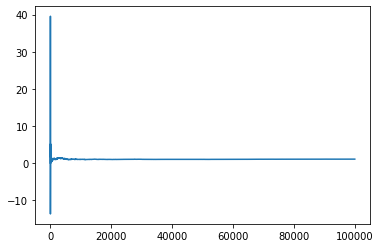

In [8]:
plt.plot(res.filtered_state[1])

<h2>Example given on <a href="http://www.overleaf.com">Link</a></h2> 


In [ ]:
"""
Univariate Local Linear Trend Model
"""
class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = k_posdef = 2

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([1, 0])
        self.ssm['transition'] = np.array([[1, 1],
                                       [0, 1]])
        self.ssm['selection'] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend']

    @property
    def start_params(self):
        return [np.std(self.endog)]*3

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]

In [91]:
mod = LocalLinearTrend(yt)
res = mod.fit()
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48342D+00    |proj g|=  5.67765D-04
  ys=-3.012E-01  -gs= 1.565E-01 BFGS update SKIPPED


 This problem is unconstrained.



At iterate    5    f=  6.21010D+00    |proj g|=  4.07811D-03

At iterate   10    f=  3.43768D+00    |proj g|=  3.09306D-01

At iterate   15    f=  3.13020D+00    |proj g|=  5.91948D-03

At iterate   20    f=  3.12672D+00    |proj g|=  1.39123D-03

At iterate   25    f=  3.12672D+00    |proj g|=  1.13442D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     67      1     1     0   7.437D-07   3.127D+00
  F =   3.1267152983234783     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                           Statespace Model Results                           
Dep. Variable:                    